In [1]:
from matplotlib import pyplot as plt
import numpy as np
import random
from IPython import display

from gomoku import Gomoku
from gomoku_with_group_map import GomokuWithGroupMap
from hand_crafted_gomoku_model import HandCraftedGomokuModel
from monte_carlo_tree_search import MonteCarloTreeSearch
from parallel_monte_carlo_tree_search import ParallelMonteCarloTreeSearch

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
shape = (19,19)

# Example with decent hand crafted model

In [4]:
game = GomokuWithGroupMap(shape)
tree_search = MonteCarloTreeSearch(game, HandCraftedGomokuModel(), 2, 10)
results = []

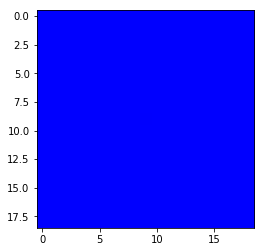

In [5]:
game.draw() 
plt.show()
for i in range(0):
    if game.game_over():
        print('Game Over')
        break
        
    result = tree_search.search()
    results.append(result)
    game.take_action(result['action'])
    
    display.clear_output(wait=True)
    print("Outcome: " + str(result['outcome']) + "  Action: " + str(result['action']))
    game.draw()    
    plt.show()

for r in results:
    print("Outcome: " + str(r['outcome']) + "  Action: " + str(r['action']))
    

# Model

In [6]:
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Activation, LeakyReLU, add
from keras.layers.core import Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import GlobalAveragePooling2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Nadam

Using TensorFlow backend.


In [7]:
def res_block(width,inp):
    x = Conv2D(width, (3,3), padding='same')(inp)
    x = LeakyReLU(alpha=0.3)(x)
    x = Conv2D(width, (3,3), padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Conv2D(width, (3,3), padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = add([x, inp])
    x = LeakyReLU(alpha=0.3)(x)
    return BatchNormalization(axis=3)(x)

In [8]:
def down_pooling_block(width,inp):
    x = Conv2D(width, (3,3), padding='same')(inp)
    x = LeakyReLU(alpha=0.3)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(2*width, (3,3), padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(4*width, (3,3), padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    return x

In [9]:
hidden_layer_count = 512

input_state= Input(shape=(shape[0],shape[1],3))
x = Conv2D(hidden_layer_count, (7,7), padding='same', activation='relu')(input_state)
x = res_block(hidden_layer_count, x)
x = res_block(hidden_layer_count, x)
x = res_block(hidden_layer_count, x)

pmx = res_block(hidden_layer_count, x)
pmx = Conv2D(1, (1,1), padding='same')(pmx)
pmx = LeakyReLU(alpha=0.3)(pmx)
pmx = Flatten()(pmx)
prob_map = Activation('softmax', name='prob_map')(pmx)

#wx = down_pooling_block(hidden_layer_count, x)
wx = res_block(hidden_layer_count, x)
wx = GlobalAveragePooling2D()(wx)
wx = Dense(hidden_layer_count)(wx)
wx = LeakyReLU(alpha=0.3)(wx)
winner = Dense(1, activation='tanh', name='winner')(wx)


model = Model(input_state, [prob_map,winner])

model.compile(
    optimizer=Nadam(), 
    loss=['categorical_crossentropy','mean_squared_error'],
    loss_weights=[1, 2]
)

In [10]:
model.load_weights('/data/trained_models/gomoku_alpha_zero_resnet_weights_v4.h5')

# Pre train with hand crafted model

In [11]:
def action_to_onehot(action):
    result = np.zeros(shape)
    result[action] = 1
    return result

def board_augmentation(inp, out):
    sym = random.choice([' ','|','\\'])
    if sym == '|':
        inp = np.flip(inp,axis=0)
        out = np.flip(out,axis=0)
    elif sym =='\\':
        inp = np.transpose(inp, axes=(1,0,2))
        out = np.transpose(out)

    k = random.randint(0,3)
    return np.rot90(inp,k=k, axes=(0,1)), np.rot90(out,k=k, axes=(0,1))
    
        

In [ ]:
game = GomokuWithGroupMap(shape)
tree_search = MonteCarloTreeSearch(game, HandCraftedGomokuModel(), 2, 4)

In [ ]:
batch_size = 64

for batch_index in range(0):
    batch_input = []
    batch_move_pred = []
    batch_win_pred = []

    for i in range(batch_size):
        if game.game_over():
            game.reset()

        result = tree_search.search()

        board, action = board_augmentation(game.get_state_for_current_player(), action_to_onehot(result['action']))
        
        batch_input.append(board)
        batch_move_pred.append(action.flatten())
        batch_win_pred.append(result['outcome'])

        game.take_action(result['action'])

        #display.clear_output(wait=True)
        #print(str(i) + " Outcome: " + str(result['outcome']) + "  Action: " + str(result['action']))
        #game.draw()    
        #plt.show()

    losses = model.train_on_batch(np.array(batch_input), [np.array(batch_move_pred), np.array(batch_win_pred)])
    print(batch_index, losses, end="\r")

# Pre train from recorded games

In [ ]:
from os import listdir
from os.path import isfile, join
import math

In [ ]:
data_path = '/data/gomoku_alpha_zero/2_10'
data_files = [f for f in listdir(data_path) if isfile(join(data_path, f))]

In [ ]:
train_boards = []
train_scores = []
train_actions = []

base = np.ones(shape)
base[game.get_middle()] += 1

for file in data_files:
    with open(data_path+"/"+file, 'r') as f:
        board = np.stack((np.zeros(shape), np.zeros(shape),np.copy(base)), axis=2)
        player = 0
        for line in f.readlines():
            line = line.split(',')
            
            original = np.copy(board)
            action = action_to_onehot((int(line[1]), int(line[2])))
            
            original, action = board_augmentation(original, action)
            
            train_boards.append(original)
            train_scores.append(float(line[0]))
            train_actions.append(action.flatten())
            
            board[int(line[1]), int(line[2]), player] = 1
            player = 1 - player
            
            

In [ ]:
len(train_actions)

In [ ]:
model.fit(np.array(train_boards), [np.array(train_actions),np.array(train_scores)], shuffle=True, epochs=1, batch_size=128)

In [ ]:
#model.save('/data/trained_models/gomoku_alpha_zero_resnet_full_model_v4_1.h5')
#model.save_weights('/data/trained_models/gomoku_alpha_zero_resnet_weights_v4_1.h5')

# Reenforment learning

In [141]:
def choice2d(pmap, count = 10):
    shape = pmap.shape
    indices = np.transpose(np.indices(shape), axes=(1,2,0)).reshape((shape[0]*shape[1],2))
    choice_indices = np.random.choice(len(indices), count, p=pmap.reshape(shape[0]*shape[1]))
    return list(map(lambda x: tuple(x), indices[choice_indices].tolist()))

class LearnedGomokuModel:
    def __init__(self, model):
        self.model = model
    
    def predict(self, boards):
        pred = model.predict(boards)
        shape = (boards.shape[0], boards.shape[1], boards.shape[2])
        return {
            'outcomes':pred[1].flatten(),
            'action_probability_maps': pred[0].reshape(shape)
        }
        

In [177]:
game = Gomoku(shape)
lmodel = LearnedGomokuModel(model)
tree_search = ParallelMonteCarloTreeSearch(LearnedGomokuModel(model), 2, 5)
results = []

Outcome: 1/0.591696  Action: (8, 6)


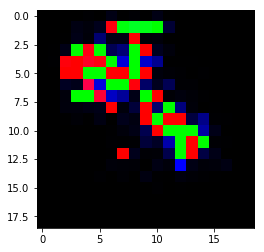

Outcome: -0.151436850429  Action: (9, 9)
Outcome: -0.0570913292468  Action: (7, 9)
Outcome: -0.154402270913  Action: (5, 7)
Outcome: -0.0776189938188  Action: (6, 7)
Outcome: -0.198656111956  Action: (6, 8)
Outcome: -0.0481200963259  Action: (6, 6)
Outcome: -0.167678266764  Action: (7, 5)
Outcome: -0.0863779708743  Action: (4, 6)
Outcome: -0.27404537797  Action: (5, 6)
Outcome: -0.00982528645545  Action: (4, 8)
Outcome: -0.245388180017  Action: (4, 5)
Outcome: -0.0917088910937  Action: (9, 10)
Outcome: -0.327641397715  Action: (12, 7)
Outcome: -0.104490756989  Action: (5, 5)
Outcome: -0.229981601238  Action: (4, 4)
Outcome: -0.257233053446  Action: (3, 8)
Outcome: -0.309314280748  Action: (10, 10)
Outcome: -0.247019439936  Action: (5, 4)
Outcome: -0.300402343273  Action: (4, 3)
Outcome: -0.316190093756  Action: (11, 12)
Outcome: -0.291483610868  Action: (9, 12)
Outcome: -0.242710247636  Action: (10, 11)
Outcome: -0.266235083342  Action: (7, 10)
Outcome: -0.343880295753  Action: (1, 10)

In [178]:
while not game.game_over():
    outcomes, actions = tree_search.search([game])
    results.append({'outcome':outcomes[0], 'action':actions[0]})
    game.take_action(actions[0])
    predicted = lmodel.predict(np.array([game.get_state_for_current_player()]))
    
    display.clear_output(wait=True)
    print("Outcome: " + str(outcomes[0]) + "/" + str(predicted['outcomes'][0]) + "  Action: " + str(actions[0]))
    pmap = predicted['action_probability_maps']
    board = game.get_state()
    plt.imshow(np.stack([board[:,:,0], board[:,:,1], pmap[0]/np.max(pmap[0])], axis = 2))
    plt.show()
    

for r in results:
    print("Outcome: " + str(r['outcome']) + "  Action: " + str(r['action']))
    

In [ ]:
lmodel = LearnedGomokuModel(model)
#lmodel = HandCraftedGomokuModel()
print(lmodel.predicted_outcome(game))
plt.imshow(lmodel.get_probability_map(game))